In [1]:
#!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

In [2]:
#!wget https://universe.roboflow.com/ds/J2gwc4lbUt?key=EDrj9yWOXp -O indoor_object_detection.zip

In [3]:
#!unzip "indoor_object_detection.zip" -d "dataset2/"

## Setup

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

from datetime import datetime

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization


2024-02-05 22:20:36.203952: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 22:20:36.448943: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 22:20:36.448992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 22:20:36.484944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-05 22:20:36.540895: I tensorflow/core/platform/cpu_feature_guar

Using TensorFlow backend


## Hyperparameters

In [5]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 2
LEARNING_RATE = 0.001
EPOCH = 50
GLOBAL_CLIPNORM = 10.0

In [6]:
class_ids = [
    #"TV", "bed", "chair", "clock", "console", "consoleeeeee", "door", "fan", "light", "sofa", "switchboard", "table"
    "emptychair", "fullchair"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "../dataset2/train/"
path_annot = "../dataset2/train/"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

In [7]:

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/4780 [00:00<?, ?it/s]

In [8]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

2024-02-05 22:21:35.707595: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 22:21:35.820538: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 22:21:35.820588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 22:21:35.825100: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 22:21:35.825143: I external/local_xla/xla/stream_executor

In [9]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [10]:
print(len(image_paths))
print(num_val)
print(train_data.__len__())

4780
956
tf.Tensor(3824, shape=(), dtype=int64)


In [11]:

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


In [12]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

## Creating Training Dataset

In [13]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

## Creating Validation Dataset

In [14]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Creating Model

In [16]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco",  # We will use yolov8 small backbone with coco weights
    #trainable = False
)

/home/andrea/.local/lib/python3.10/site-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/andrea/.local/lib/python3.10/site-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [17]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    #fpn_depth=1
)
#yolo.summary()

In [18]:
#for layer in yolo.layers:
#    if "yolo_v8_head" in layer.name:
#        #print(layer.name + " - " + str(layer.trainable))
#        layer.trainable = True
#    else:
#        layer.trainable = False
#        
#yolo.summary()

## Compile the Model

In [19]:
yolo.load_weights("model-s-test2.h5")
#yolo = keras_cv.models.load("model.h5")

In [20]:
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)
#yolo.summary()

In [21]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        #self.best_map = -1.0
        self.best_map = 999

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        #for batch in self.data:
        #    images, y_true = batch[0], batch[1]
        #    y_pred = self.model.predict(images, verbose=0)
        #    self.metrics.update_state(y_true, y_pred)

        #metrics = self.metrics.result(force=False)
        #logs.update(metrics)

        #print(metrics)
        #current_map = metrics["MaP"]
        current_map = logs["val_loss"]
        if current_map < self.best_map:
            self.best_map = current_map
            now = datetime.now()
            #self.model.save(self.save_path + "-test2"+ now.strftime("-%m%d%Y-%H%M%S") + ".h5")
            self.model.save(self.save_path + "-test2.h5")

        return logs


In [22]:
#yolo.save("model_3ep.h5")

## Train the Model

In [23]:
# definizione di due callback per migliorare l'addestramento
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model-s"), early_stopping, reduce_lr]
)

Epoch 1/50


2024-02-05 22:22:02.631410: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-05 22:22:06.118266: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-05 22:22:09.030937: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-05 22:22:26.718763: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-05 22:22:26.809158: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance 

1912/1912 [==============================] - ETA: 0s - loss: 1.2985 - box_loss: 0.9836 - class_loss: 0.3149WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


/home/andrea/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1912/1912 [==============================] - 486s 224ms/step - loss: 1.2985 - box_loss: 0.9836 - class_loss: 0.3149 - val_loss: 3.0077 - val_box_loss: 1.5343 - val_class_loss: 1.4734 - lr: 0.0010
Epoch 2/50
1912/1912 [==============================] - ETA: 0s - loss: 1.2966 - box_loss: 0.9781 - class_loss: 0.3185

2024-02-05 22:36:05.012986: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 398s 208ms/step - loss: 1.2966 - box_loss: 0.9781 - class_loss: 0.3185 - val_loss: 3.3391 - val_box_loss: 1.7188 - val_class_loss: 1.6202 - lr: 0.0010
Epoch 3/50
   1/1912 [..............................] - ETA: 14:00 - loss: 0.7700 - box_loss: 0.2216 - class_loss: 0.5484

2024-02-05 22:36:33.588505: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 1.2666 - box_loss: 0.9585 - class_loss: 0.3082

2024-02-05 22:42:43.491932: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 397s 207ms/step - loss: 1.2666 - box_loss: 0.9585 - class_loss: 0.3082 - val_loss: 3.5420 - val_box_loss: 1.9421 - val_class_loss: 1.5999 - lr: 0.0010
Epoch 4/50
   1/1912 [..............................] - ETA: 15:05 - loss: 1.1161 - box_loss: 0.4371 - class_loss: 0.6791

2024-02-05 22:43:10.698156: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 1.2695 - box_loss: 0.9667 - class_loss: 0.3029

2024-02-05 22:49:18.929445: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 395s 206ms/step - loss: 1.2695 - box_loss: 0.9667 - class_loss: 0.3029 - val_loss: 3.4756 - val_box_loss: 1.7458 - val_class_loss: 1.7298 - lr: 0.0010
Epoch 5/50


2024-02-05 22:49:46.129202: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 1.2418 - box_loss: 0.9377 - class_loss: 0.3041

2024-02-05 22:55:55.164130: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 396s 207ms/step - loss: 1.2418 - box_loss: 0.9377 - class_loss: 0.3041 - val_loss: 3.3522 - val_box_loss: 1.8069 - val_class_loss: 1.5453 - lr: 0.0010
Epoch 6/50


2024-02-05 22:56:22.229658: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 1.2511 - box_loss: 0.9519 - class_loss: 0.2992

2024-02-05 23:02:30.942280: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 396s 207ms/step - loss: 1.2511 - box_loss: 0.9519 - class_loss: 0.2992 - val_loss: 3.4411 - val_box_loss: 1.8510 - val_class_loss: 1.5901 - lr: 0.0010
Epoch 7/50


2024-02-05 23:02:58.173412: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 1.1978 - box_loss: 0.8872 - class_loss: 0.3106

2024-02-05 23:09:06.973119: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 397s 208ms/step - loss: 1.1978 - box_loss: 0.8872 - class_loss: 0.3106 - val_loss: 2.6808 - val_box_loss: 1.4198 - val_class_loss: 1.2610 - lr: 1.0000e-04
Epoch 8/50


2024-02-05 23:09:35.656375: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 1.1102 - box_loss: 0.8344 - class_loss: 0.2758

2024-02-05 23:15:44.327648: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 397s 207ms/step - loss: 1.1102 - box_loss: 0.8344 - class_loss: 0.2758 - val_loss: 2.6314 - val_box_loss: 1.3839 - val_class_loss: 1.2475 - lr: 1.0000e-04
Epoch 9/50
1912/1912 [==============================] - ETA: 0s - loss: 1.0872 - box_loss: 0.8225 - class_loss: 0.2647

2024-02-05 23:22:22.344114: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 398s 208ms/step - loss: 1.0872 - box_loss: 0.8225 - class_loss: 0.2647 - val_loss: 2.6307 - val_box_loss: 1.4022 - val_class_loss: 1.2285 - lr: 1.0000e-04
Epoch 10/50
1912/1912 [==============================] - 397s 207ms/step - loss: 1.0664 - box_loss: 0.8112 - class_loss: 0.2552 - val_loss: 2.7020 - val_box_loss: 1.3832 - val_class_loss: 1.3188 - lr: 1.0000e-04
Epoch 11/50


2024-02-05 23:29:28.040424: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 1.0491 - box_loss: 0.7957 - class_loss: 0.2533

2024-02-05 23:35:36.852472: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 397s 207ms/step - loss: 1.0491 - box_loss: 0.7957 - class_loss: 0.2533 - val_loss: 2.6257 - val_box_loss: 1.3531 - val_class_loss: 1.2726 - lr: 1.0000e-04
Epoch 12/50
1912/1912 [==============================] - ETA: 0s - loss: 1.0363 - box_loss: 0.7906 - class_loss: 0.2457

2024-02-05 23:42:13.961685: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 396s 207ms/step - loss: 1.0363 - box_loss: 0.7906 - class_loss: 0.2457 - val_loss: 2.6696 - val_box_loss: 1.3668 - val_class_loss: 1.3028 - lr: 1.0000e-04
Epoch 13/50


2024-02-05 23:42:41.251267: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 1.0339 - box_loss: 0.7880 - class_loss: 0.2459

2024-02-05 23:48:50.731421: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 396s 207ms/step - loss: 1.0339 - box_loss: 0.7880 - class_loss: 0.2459 - val_loss: 2.7523 - val_box_loss: 1.3659 - val_class_loss: 1.3864 - lr: 1.0000e-04
Epoch 14/50


2024-02-05 23:49:17.900890: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 1.0275 - box_loss: 0.7863 - class_loss: 0.2411

2024-02-05 23:55:27.614596: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 397s 207ms/step - loss: 1.0275 - box_loss: 0.7863 - class_loss: 0.2411 - val_loss: 2.7605 - val_box_loss: 1.3689 - val_class_loss: 1.3916 - lr: 1.0000e-04
Epoch 15/50


2024-02-05 23:56:40.385724: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 1.0233 - box_loss: 0.7806 - class_loss: 0.2427

2024-02-06 00:02:48.070412: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 395s 206ms/step - loss: 1.0233 - box_loss: 0.7806 - class_loss: 0.2427 - val_loss: 2.8061 - val_box_loss: 1.3839 - val_class_loss: 1.4222 - lr: 1.0000e-04
Epoch 16/50


2024-02-06 00:03:15.333378: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 1.0099 - box_loss: 0.7732 - class_loss: 0.2366

2024-02-06 00:09:25.344775: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 397s 207ms/step - loss: 1.0099 - box_loss: 0.7732 - class_loss: 0.2366 - val_loss: 2.8950 - val_box_loss: 1.4009 - val_class_loss: 1.4940 - lr: 1.0000e-04
Epoch 17/50


2024-02-06 00:10:37.843916: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 397s 207ms/step - loss: 1.0219 - box_loss: 0.7673 - class_loss: 0.2547 - val_loss: 2.5665 - val_box_loss: 1.3351 - val_class_loss: 1.2314 - lr: 1.0000e-05
Epoch 18/50
1912/1912 [==============================] - ETA: 0s - loss: 1.0186 - box_loss: 0.7737 - class_loss: 0.2448

2024-02-06 00:23:24.849668: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 398s 208ms/step - loss: 1.0186 - box_loss: 0.7737 - class_loss: 0.2448 - val_loss: 2.4854 - val_box_loss: 1.3349 - val_class_loss: 1.1505 - lr: 1.0000e-05
Epoch 19/50


2024-02-06 00:23:53.465874: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 1.0106 - box_loss: 0.7664 - class_loss: 0.2441

2024-02-06 00:30:04.028348: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 398s 208ms/step - loss: 1.0106 - box_loss: 0.7664 - class_loss: 0.2441 - val_loss: 2.5448 - val_box_loss: 1.3358 - val_class_loss: 1.2090 - lr: 1.0000e-05
Epoch 20/50


2024-02-06 00:30:31.390291: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 0.9970 - box_loss: 0.7569 - class_loss: 0.2402

2024-02-06 00:36:43.352945: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 400s 209ms/step - loss: 0.9970 - box_loss: 0.7569 - class_loss: 0.2402 - val_loss: 2.6058 - val_box_loss: 1.3448 - val_class_loss: 1.2610 - lr: 1.0000e-05
Epoch 21/50


2024-02-06 00:37:11.647115: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 1.0011 - box_loss: 0.7593 - class_loss: 0.2418

2024-02-06 00:43:26.905252: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 402s 210ms/step - loss: 1.0011 - box_loss: 0.7593 - class_loss: 0.2418 - val_loss: 2.6516 - val_box_loss: 1.3584 - val_class_loss: 1.2933 - lr: 1.0000e-05
Epoch 22/50
   1/1912 [..............................] - ETA: 15:28 - loss: 0.1762 - box_loss: 0.0994 - class_loss: 0.0767

2024-02-06 00:43:54.471780: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 0.9952 - box_loss: 0.7586 - class_loss: 0.2365

2024-02-06 00:50:05.511144: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 398s 208ms/step - loss: 0.9952 - box_loss: 0.7586 - class_loss: 0.2365 - val_loss: 2.5497 - val_box_loss: 1.3296 - val_class_loss: 1.2201 - lr: 1.0000e-05
Epoch 23/50


2024-02-06 00:50:32.824799: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 0.9909 - box_loss: 0.7556 - class_loss: 0.2354

2024-02-06 00:56:44.349486: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 398s 208ms/step - loss: 0.9909 - box_loss: 0.7556 - class_loss: 0.2354 - val_loss: 2.6032 - val_box_loss: 1.3580 - val_class_loss: 1.2453 - lr: 1.0000e-05
Epoch 24/50


2024-02-06 00:57:11.839778: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 396s 207ms/step - loss: 1.0039 - box_loss: 0.7634 - class_loss: 0.2405 - val_loss: 2.5432 - val_box_loss: 1.3503 - val_class_loss: 1.1929 - lr: 1.0000e-06
Epoch 25/50


2024-02-06 01:03:48.541665: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 0.9904 - box_loss: 0.7521 - class_loss: 0.2383

2024-02-06 01:09:56.936730: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 395s 207ms/step - loss: 0.9904 - box_loss: 0.7521 - class_loss: 0.2383 - val_loss: 2.5182 - val_box_loss: 1.3545 - val_class_loss: 1.1637 - lr: 1.0000e-06
Epoch 26/50


2024-02-06 01:10:24.198972: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 0.9940 - box_loss: 0.7573 - class_loss: 0.2366

2024-02-06 01:16:34.328369: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 397s 207ms/step - loss: 0.9940 - box_loss: 0.7573 - class_loss: 0.2366 - val_loss: 2.5604 - val_box_loss: 1.3468 - val_class_loss: 1.2135 - lr: 1.0000e-06
Epoch 27/50


2024-02-06 01:17:01.494780: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 0.9884 - box_loss: 0.7541 - class_loss: 0.2344

2024-02-06 01:23:12.056274: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 397s 208ms/step - loss: 0.9884 - box_loss: 0.7541 - class_loss: 0.2344 - val_loss: 2.4942 - val_box_loss: 1.3240 - val_class_loss: 1.1702 - lr: 1.0000e-06
Epoch 28/50


2024-02-06 01:23:39.297562: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 0.9918 - box_loss: 0.7572 - class_loss: 0.2345

2024-02-06 01:29:50.956208: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 399s 208ms/step - loss: 0.9918 - box_loss: 0.7572 - class_loss: 0.2345 - val_loss: 2.5554 - val_box_loss: 1.3694 - val_class_loss: 1.1859 - lr: 1.0000e-06


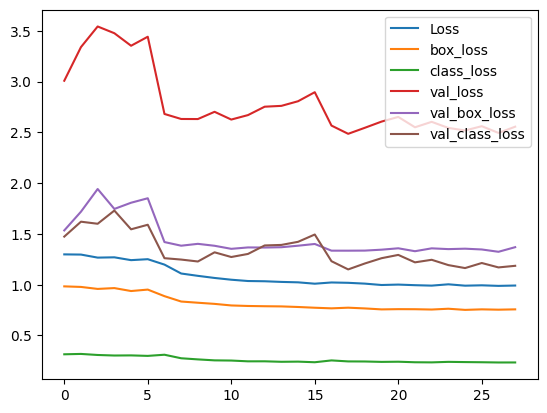

In [24]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['box_loss'], label='box_loss')
plt.plot(history.history['class_loss'], label='class_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_box_loss'], label='val_box_loss')
plt.plot(history.history['val_class_loss'], label='val_class_loss')
plt.legend(loc="upper right")
plt.show()

In [25]:
now = datetime.now()
pd.DataFrame.from_dict(history.history).to_csv('model-s-test2-history' + now.strftime("-%m%d%Y-%H%M%S") + '.csv',index=False)